In [1]:
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from skimage import data
from skimage import io
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from skimage.color import rgb2gray

## IncuCyte TMRE assay
This program will take background subtracted TIFF files from IncuCyte fluorescence microscope and assign TMRE fluorescence filtered based on co-localization with NAO fluorescence. TMRE intensity is controlled by the mitochondrial membrane potential in a Nernstian fashion. NAO is supposed to be a membrane potential independent mitochondrial stain; however, it is certainly not - like any cationic dye its mitochondrial localization is affected be the membrane potential. Still, NAO can be used as a filter and the program uses the NAO channel to filter pixels containing mitochondria, then applies this filter to the TMRE channel.

It works by the following steps:
1. Find minimum NAO intensity percentile using 100 - confluency/alpha, where alpha can be adjusted up/down to only extract mitochondria.
2. Filter between the minimum NAO intensity percentile and the maximum 98 percentile.
3. Filter TMRE channel between 0 and 98 percentile.
4. Apply both filters to TMRE/NAO channels.
5. Find the average TMRE fluorescence intensity for all non-filtered pixels.


##  How to use
Step-wise guide on how to use:
1. Treat cells with drug either acutely or with time for adaptation e.g. 24 h. Cells should be 70-100% confluent after treatment.
2. Add 1-20 nM TMRE (non-quencing concentration has to be determined emperically, 15 nM is a good starting point) and 30 nM NAO, mix and move plates to IncuCyte.
3. After 30-60 min incubation start imaging each well with 4 fields of view per well. Do not use more fields per view to minimize the time from first to last well, to avoid signal drift. Use the "Adeherent Cell-by-Cell" option with 20x resolution and image phase, GFP and RFP channels using default values. Images can be gathered with a cycle time of 30-60 min, 2-4 cycles are enough.
4. Run an analysis on the gathered images to remove background fluorescence which is particularly high in the GFP channel. Correct RFP to GFP bleed by subtracting 10% of the RFP channel from the GFP channel. Use the Top-Hat background subtraction and adjust the parameter for cell diameter (14 μm is a good starting point).
5. To download the background subtracted image files pres the "Export Images and Movies" button on the lower left side of the image tab, then choose "As Displayed". Then select a single channel, e.g. GFP, and manually adjust the intensity range to go from 0 to the ~99 percentile of the max value. To find this fiddle around with the max intensity. If a too low max intensity is chosen a large fraction of the image pixels will be set to their saturated values and thereby information is lost. Finally, select one image per well for export and be sure to export the same image in both channels.
6. Download all TIFF images and put into a folder structure on a per plate basis with subfolders for GFP and RFP channels e.g. (RFP and GFP must be capitalized):

   --> plate1
         --> GFP
         --> RFP
   --> plate2
         --> GFP
         --> RFP  

7. Set input parameters i.e. name of the plate folders, plate dimensions and approximate confluency (minimum 10%).
8. Run the functions to read and assign TMRE.
9. Check percentiles are correct by visual inspection using plotting.

## Set input parameters

In [2]:
plate_folders = ['Antimycin', 'BAM15']
conf_est = 80 # Minimum confluency is 10%
assert(conf_est >= 10)
plate_dim = (3, 4) # Number of rows, columns on plate

## Main program

In [3]:
# Utility dictionaries:
percentile_dict = {'GFP': {'min': 100 - conf_est/10, 'max': 98},
                   'RFP': {'min': 0, 'max': 98}}
abc2int = {a:n for a, n in zip(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], [0, 1, 2, 3, 4, 5, 6, 7])}

In [4]:
def combine_image(image_list):
    '''
    Combines a list of images that are different field of views
    from the same well.
    '''
    Ndim = int(len(image_list)**0.5)
    image_cols = []
    image_idx = 0
    for i in range(0, Ndim):
        image_row = [image_list[j] for j in range(image_idx, image_idx+Ndim)]
        image_idx += Ndim
        row_cat = np.concatenate(image_row, axis=1)
        image_cols.append(row_cat)
    return(np.concatenate(image_cols, axis=0))

In [5]:
def read_images(plate_folders):
    '''
    Read the images in the folder structure into a dictionary
    that pairs each field of view image with its corresponding well.
    '''
    # Dict to hold all image information, structure:
    # image_dict[plate][well][time]['[GR]FP'][path_list] = list(paths)
    # image_dict[plate][well][time]['[GR]FP'][imat] = combined image (matrix format)
    # image_dict[plate][well][time]['[TMRE_avg] = RFP/GFP (normalized TMRE signal)
    image_dict = dict()

    for plate in plate_folders:
        # Glob to find all TIFF files:
        data_path = Path(plate)
        gfp_files = list(data_path.glob('GFP/*.tif'))
        rfp_files = list(data_path.glob('RFP/*.tif'))

        image_dict[plate] = dict()
        # Read all GFP (NAO) channel images:
        for p in natsorted(gfp_files):
            cols = str(p).split('_')
            assert(cols[1][0] in abc2int and cols[1][1] in '0123456789') # assert this column contains the well ID
            if cols[1] not in image_dict[plate]:
                image_dict[plate][cols[1]] = dict()
            if cols[3] not in image_dict[plate][cols[1]]:
                # New well entry, to hold all image information:
                image_dict[plate][cols[1]][cols[3]] = {'TMRE_avg': None, 'GFP': {'path_list': [], 'imat': None}, 'RFP': {'path_list': [], 'imat': None}}
            # Store each field of view belonging to the well:
            image_dict[plate][cols[1]][cols[3]]['GFP']['path_list'].append(p)

        # Read the RFP (TMRE) images:
        for p in natsorted(rfp_files):
            cols = str(p).split('_')
            assert(cols[1][0] in abc2int and cols[1][1] in '0123456789') # assert this column contains the well ID
            image_dict[plate][cols[1]][cols[3]]['RFP']['path_list'].append(p)
            
        # Collect and merge all the fields of view per well into one image:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                for fl in ['GFP', 'RFP']: # first handle GFP channel
                    image_list = list()
                    for filename in image_dict[plate][well][time][fl]['path_list']:
                        image_list.append(rgb2gray(io.imread(filename)))
                    image_dict[plate][well][time][fl]['imat'] = combine_image(image_list)
    
    return(image_dict)

In [6]:
def filter_images(image_dict, percentile_dict):
    '''
    Combine all the fields of view per well into one image.
    Then apply filters and calculate the normalizated TMRE.
    '''
    # Dataframe to store the normalizated TMRE values:
    TMRE_df = pd.DataFrame(columns=['Plate', 'Well', 'Time', 'TMRE_avg'])
    row_idx = 0

    for plate in image_dict:
        for well in image_dict[plate]:
            for time in image_dict[plate][well]:
                master_mask = None
                for fl in ['GFP', 'RFP']: # first handle GFP channel
                    # Find the percentile cutoff values:
                    fl_min = np.percentile(image_dict[plate][well][time][fl]['imat'], percentile_dict[fl]['min'])
                    fl_max = np.percentile(image_dict[plate][well][time][fl]['imat'], percentile_dict[fl]['max'])
                    # Find all pixels that are not within the percentile cutoff:
                    mask = (image_dict[plate][well][time][fl]['imat'] < fl_min) | (image_dict[plate][well][time][fl]['imat'] > fl_max)
                    # Update master mask:
                    if master_mask is None:
                        master_mask = mask
                    else:
                        master_mask = master_mask | mask
                # Filter both channels based on the master mask:
                for fl in ['GFP', 'RFP']:
                    image_dict[plate][well][time][fl]['imat'][master_mask] = 0
                # Calculate the normalized TMRE, per pixel and average,
                # note, master_mask is reversed:
                # TMRE normalized to NAO:
                # image_dict[plate][well][time]['TMRE_avg'] = np.average(image_dict[plate][well][time]['RFP']['imat'][~master_mask] / image_dict[plate][well][time]['GFP']['imat'][~master_mask])
                # Average TMRE filtered on co-localization with NAO:
                image_dict[plate][well][time]['TMRE_avg'] = np.average(image_dict[plate][well][time]['RFP']['imat'][~master_mask])
                TMRE_df.loc[row_idx] = [plate, well, time[:-4], image_dict[plate][well][time]['TMRE_avg']]
                row_idx += 1

    return(image_dict, TMRE_df)

In [7]:
def plot_plate(plate_imat, fl, image_name, image_shape, plate_dim):
    '''
    Plot one plate with formatting.
    '''
    # The merged field of view is not perfectly square,
    # so sizing has to be adjusted:
    fig = plt.figure(figsize=(plate_dim[1]*3, (image_shape[0] / image_shape[1])*plate_dim[0]*3))
    gs = GridSpec(*plate_dim, figure=fig, hspace=0.05)
    # Choosing generic green/red color gradients for GFP/RFP channels: 
    if fl == 'GFP':
        color = 'Greens'
    elif fl == 'RFP':
        color = 'Reds'
    for i in range(plate_dim[0]):
        for j in range(plate_dim[1]):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(plate_imat[i][j], color)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.set_aspect('equal')
    fig.suptitle('{}'.format(image_name))
    fig.subplots_adjust(wspace=0, hspace=0)
    return(fig)

In [8]:
def plot_all(image_dict, plate_dim):
    '''
    Plot the merged and filtered images
    in the shape of the well.
    '''
    plate = list(image_dict.keys())[0]
    well = list(image_dict[plate].keys())[0]
    time = list(image_dict[plate][well].keys())[0]
    time_list = image_dict[plate][well].keys()
    fl_list = ['GFP', 'RFP']
    image_shape = image_dict[plate][well][time]['GFP']['imat'].shape

    fig_list = list()
    for plate in image_dict:
        for time in natsorted(time_list):
            if time not in image_dict[plate][well]:
                continue
            for fl in fl_list:
                # Placeholder matrix to hold the "imat" matrices of
                # the merged image from each well:
                plate_imat = [[None for j in range(plate_dim[1])] for i in range(plate_dim[0])]
                # Fill the "plate_imat":
                for well in image_dict[plate]:
                    i = abc2int[well[0]]
                    j = int(well[1:]) - 1
                    plate_imat[i][j] = image_dict[plate][well][time][fl]['imat']

                # Plot one plate:
                image_name = '{} {} {}'.format(plate, fl, time)
                fig = plot_plate(plate_imat, fl, image_name, image_shape, plate_dim)
                fig_list.append(fig)
    return(fig_list)

In [9]:
# Read images into dict:
image_dict = read_images(plate_folders)

In [10]:
# Filter and calculate normalized TMRE:
image_dict, TMRE_df = filter_images(image_dict, percentile_dict)

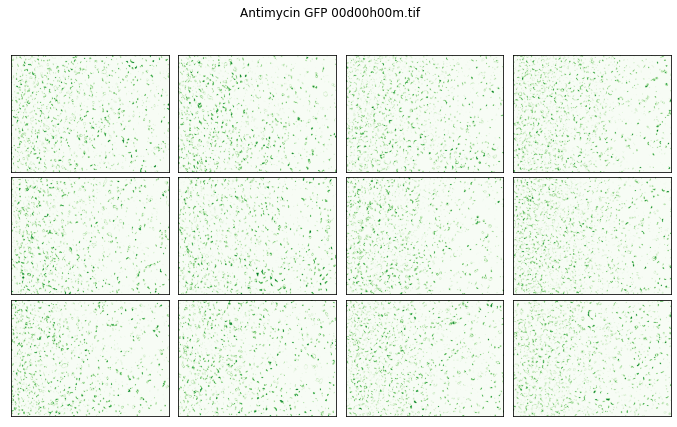

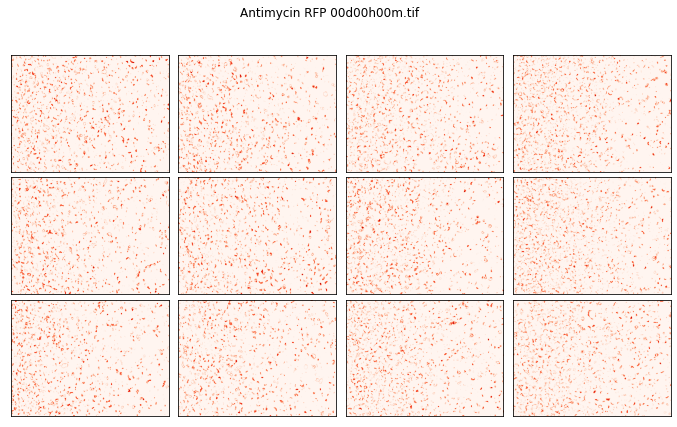

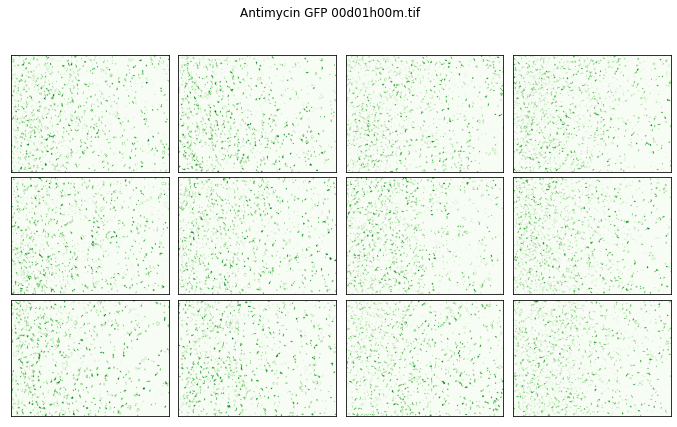

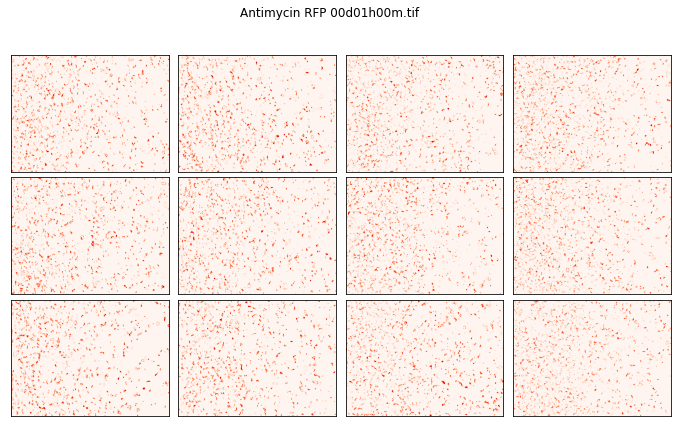

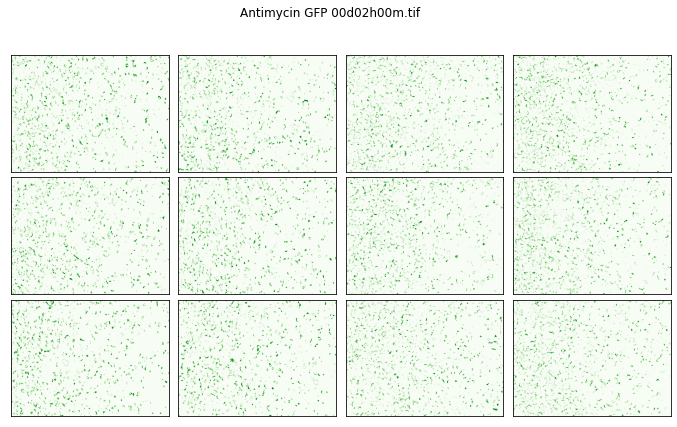

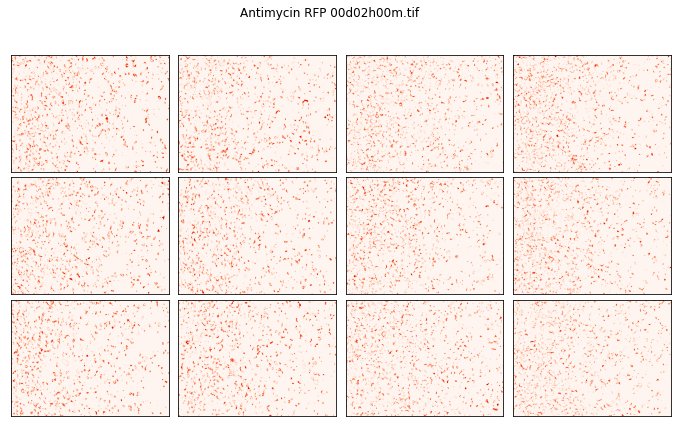

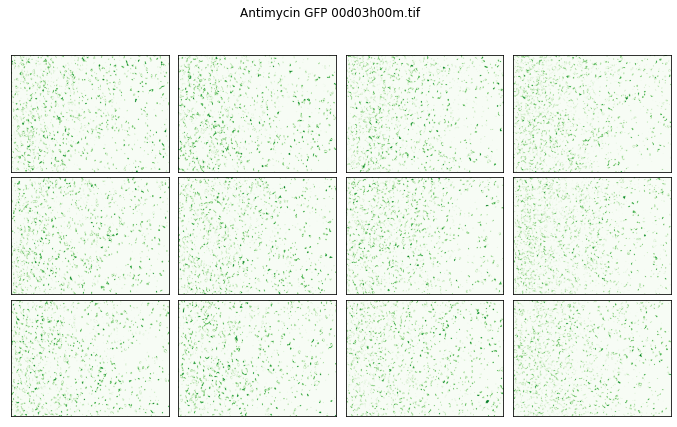

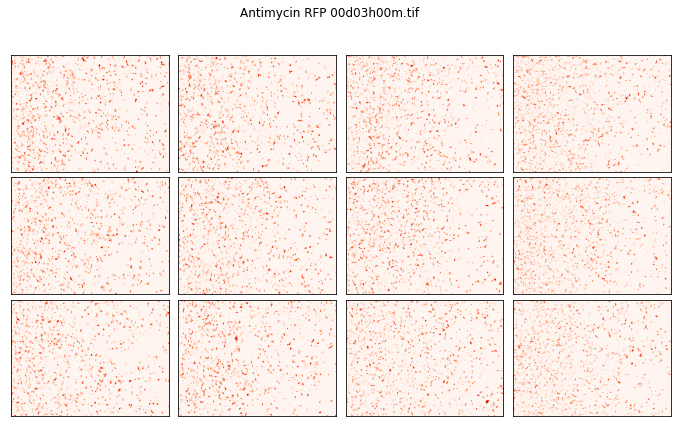

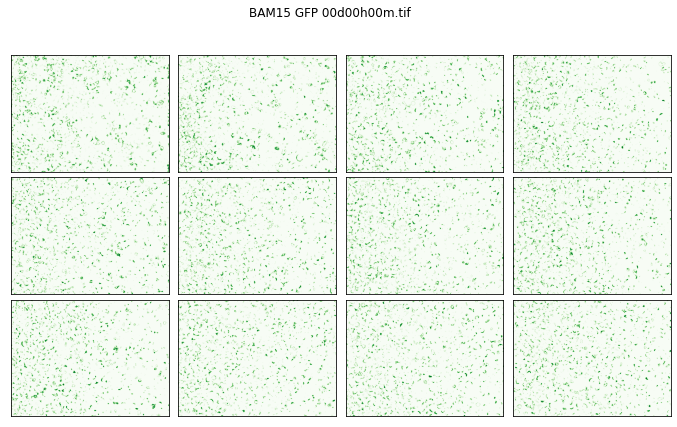

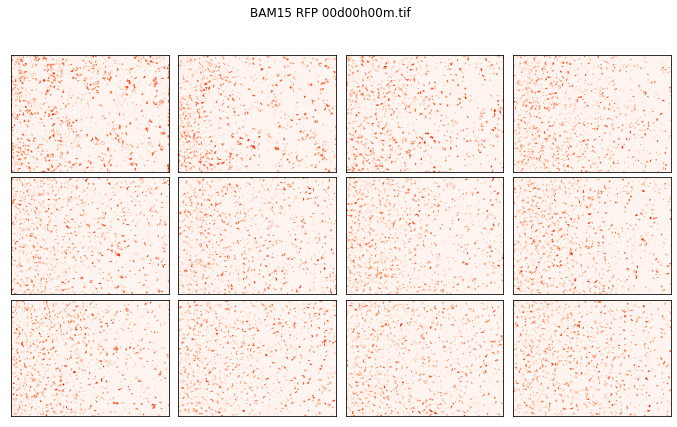

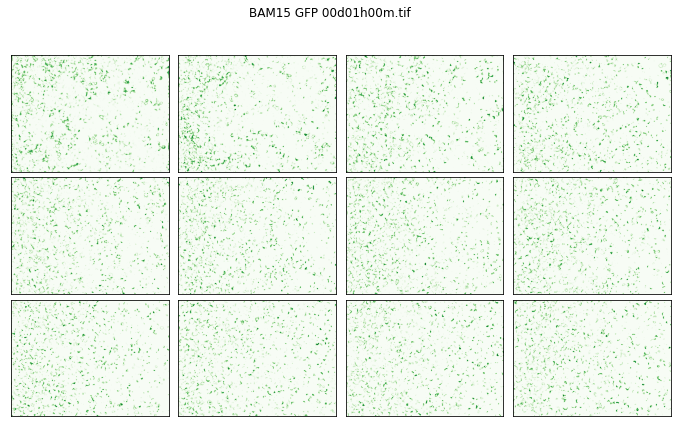

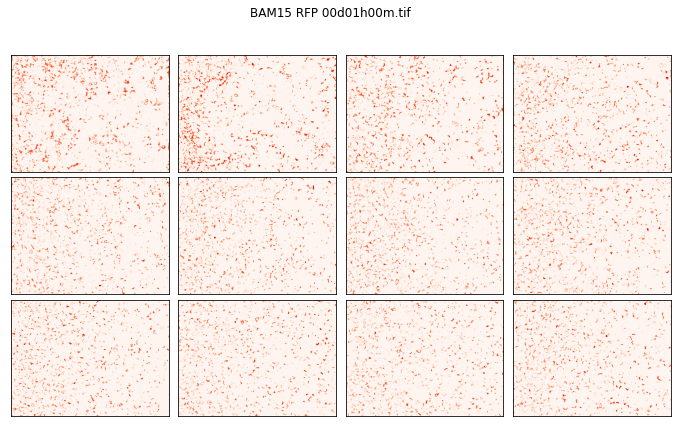

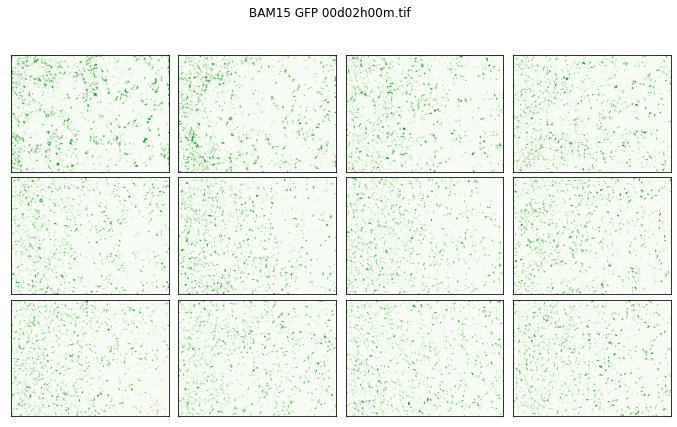

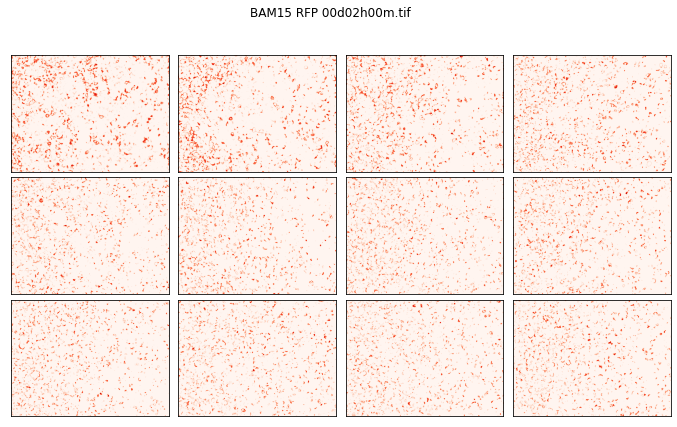

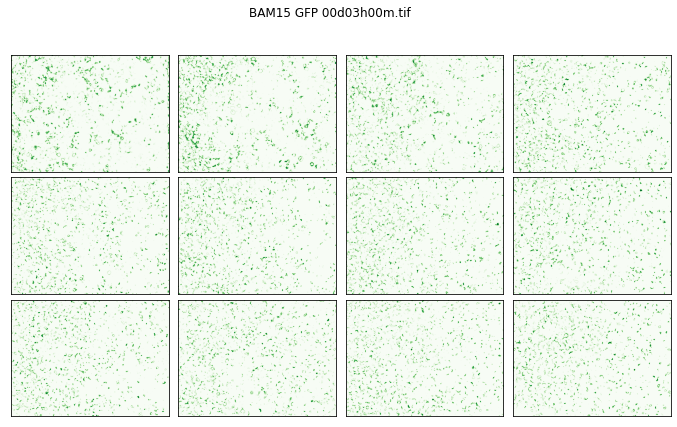

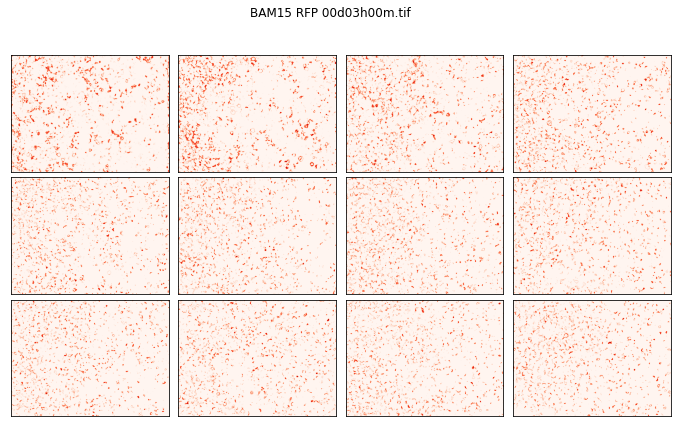

In [11]:
# Plot images after filters have been applied
# to verify correct settings:
fig_list = plot_all(image_dict, plate_dim)

In [16]:
conc = [10000/2**i for i in range(11)] + [1]
wells = [l+n for l in ['A', 'B', 'C'] for n in ['1', '2', '3', '4']]
#### !!!! Maybe last row is reversed???
#conc[8:12] = conc[8:12][::-1]
conc = np.array(conc)
well2conc = {w:c for w, c in zip(wells, conc)}




In [17]:
TMRE_df['Conc'] = [well2conc[w] for w in TMRE_df['Well'].values]

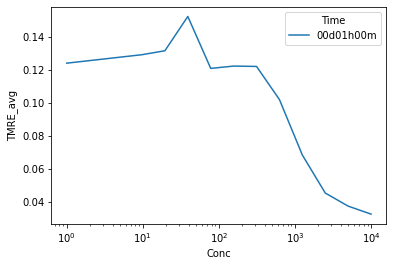

In [21]:
mask = (TMRE_df['Plate'] == 'BAM15') & (TMRE_df['Time'] == '00d01h00m')
g1 = sns.lineplot(x='Conc', y='TMRE_avg', hue='Time', data=TMRE_df[mask])
g1.set_xscale('log')


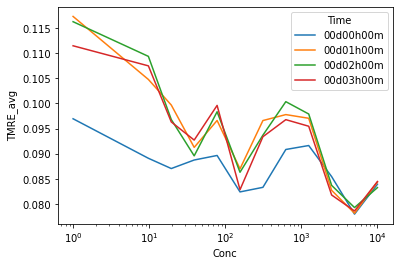

In [19]:
mask = TMRE_df['Plate'] == 'Antimycin'
g1 = sns.lineplot(x='Conc', y='TMRE_avg', hue='Time', data=TMRE_df[mask])
g1.set_xscale('log')
